In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import torchvision

In [ ]:
projectPath = r"Osteoporosis Knee X-ray"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

# visualization of process (skip this if you just want to run segmentation)

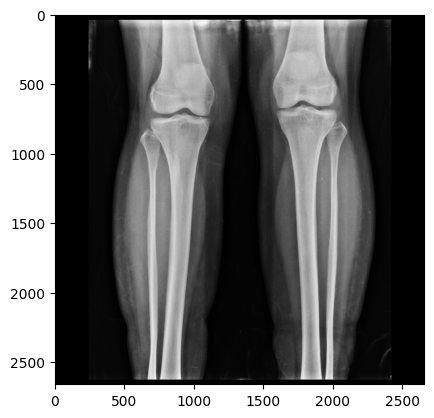

In [60]:
#read and apply square padding + grayscale
img = cv2.imread(pathList[160]) 
height, width,channel = img.shape
# Create a black image
x = height if height > width else width
y = height if height > width else width
# overlay image ontop of black square
square= np.zeros((x,y,3), np.uint8)
square[int((y-height)/2):int(y-(y-height)/2), int((x-width)/2):int(x-(x-width)/2)] = img
# convert to grayscale
gray = cv2.cvtColor(square,cv2.COLOR_BGR2GRAY)
# hsv = cv2.cvtColor(square, cv2.COLOR_BGR2HSV)
# # plt.hist(hsv[:,:,2].ravel(),256,[0,256])
# print(hsv.shape)
# plt.imshow(hsv[:,:,2], cmap='gray')
plt.imshow(gray, cmap='gray')

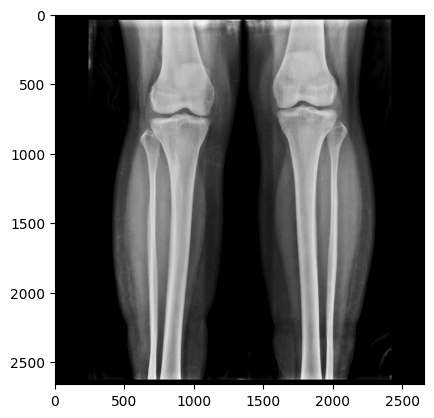

In [74]:
# apply thresholding
# for some reason, cv2.THRESH_BINARY performs worse than cv2.THRESH_TOZERO
# dont ask why

hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
# Find the most frequent color
dominant = np.argmax(hist)
_, thresholded = cv2.threshold(gray, dominant+10, 255, cv2.THRESH_TOZERO)
plt.imshow(thresholded, cmap='gray')

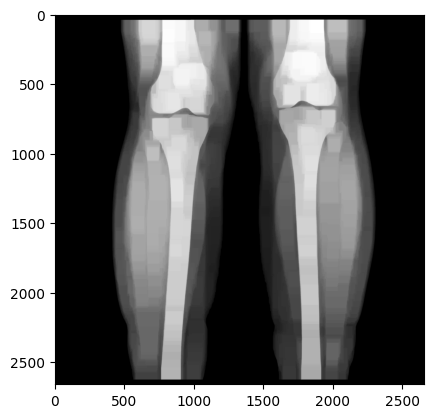

In [75]:
# reduce noise
thresholded = cv2.erode(thresholded, None, iterations=40)
thresholded = cv2.dilate(thresholded, None, iterations=40)
plt.imshow(thresholded, cmap='gray')

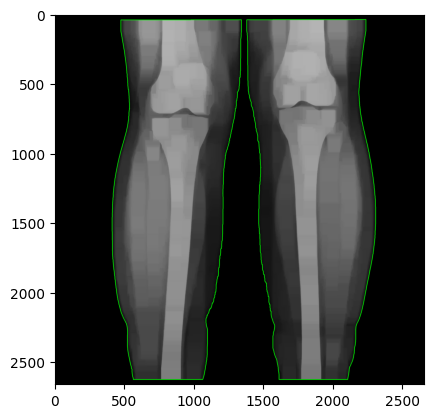

In [72]:
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours
image = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
plt.imshow(image, cmap='gray')

# segment images

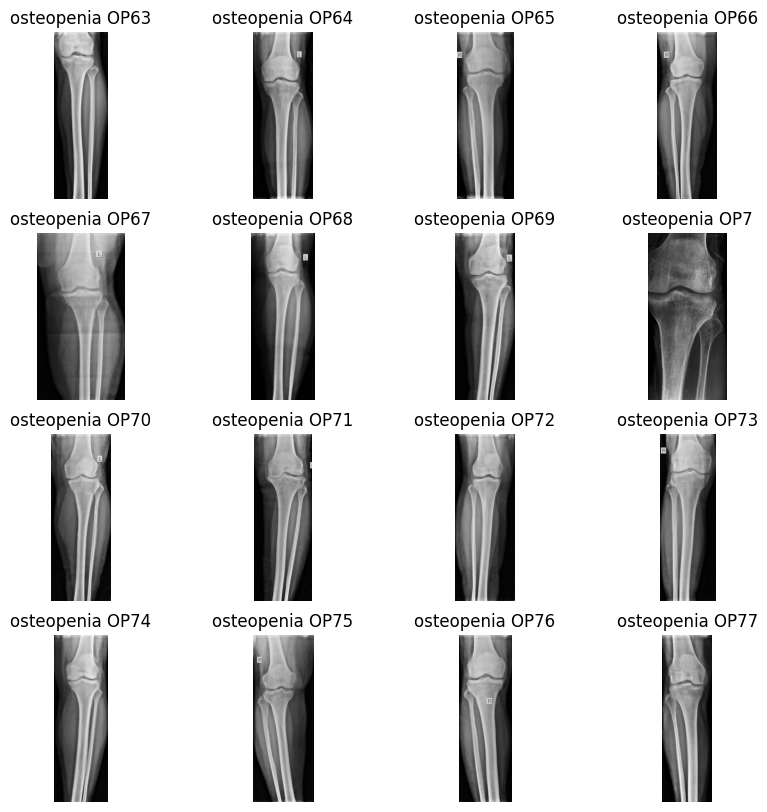

In [97]:
def apply_threshold(image_path,threshFunc):  #function to apply thresholding to an image, returns a list of segmented images
    # Read the image
    originalImage = cv2.imread(image_path)
    originalImage = cv2SquarePad(originalImage)
    originalImage = cv2.resize(originalImage, (1024,1024)) # dont forget to change erode iterations to match image size
    image = cv2.normalize(originalImage, None, alpha= 0, beta=255, norm_type=cv2.NORM_MINMAX, dtype= -1)
    dominant = findDominantColor(image)
    # return image
    # image = cv2.equalizeHist(image)
    # return image
    # Apply a binary threshold
    _, thresholded = cv2.threshold(image, dominant+10, 255, threshFunc)
    iterations = 80
    thresholded = cv2.erode(thresholded, None, iterations=iterations)
    thresholded = cv2.dilate(thresholded, None, iterations=iterations)
    # return thresholded
    boxes = findContour(thresholded)
    segments = []
    for x in boxes:
        x,y,w,h = x
        segments.append(originalImage[y:y+h, x:x+w])
    return segments

def findDominantColor(image):
    # Find the histogram of the image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Find the most frequent color
    color = np.argmax(hist)
    return color

def cv2SquarePad(image):
    height, width,channel = image.shape
    # Create a black image
    x = height if height > width else width
    y = height if height > width else width
    # overlay image ontop of black square
    square= np.zeros((x,y,3), np.uint8)
    square[int((y-height)/2):int(y-(y-height)/2), int((x-width)/2):int(x-(x-width)/2)] = image
    # convert to grayscale
    gray = cv2.cvtColor(square,cv2.COLOR_BGR2GRAY)
    return gray

def findContour(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

    boxes = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        # boxes = image[y:y+h, x:x+w]
        boxes.append((x,y,w,h))
        # cv2.imwrite(f'contour_{i}_{image_path.split("/")[-1]}', roi)
    return boxes

offset = 150 #offsets to watch out in particular: 10,20,150,200,210
# Apply threshold to 16 images
thresholded_images = [apply_threshold(path,cv2.THRESH_TOZERO) for path in pathList[offset:offset+16]]
plt.figure(figsize=(10, 10))
for i, img in enumerate(thresholded_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[0], cmap='gray')
    plt.title(f'{pathList[offset+i].split("/")[1]} {pathList[offset+i].split("/")[2].strip(".jpg").strip(".JPEG")}')
    plt.axis('off')

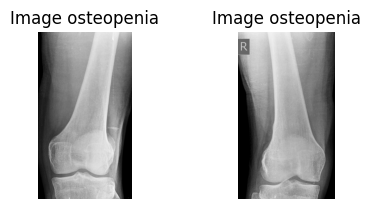

In [98]:
# code to debug the thresholding function/problematic images, runs and plots for *one* image
debug = apply_threshold(r"C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\Osteoporosis Knee X-ray\normal\N3.JPEG",cv2.THRESH_TOZERO)
plt.figure(figsize=(10, 10))
for i, img in enumerate(debug):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image {pathList[offset+i].split("/")[1]}')
    plt.axis('off')

In [99]:
segCount = {}
import shutil
shutil.rmtree('segmentedImages')
os.mkdir("segmentedImages")
os.mkdir("segmentedImages/normal")  
os.mkdir("segmentedImages/osteopenia")
os.mkdir("segmentedImages/osteoporosis")

for x in pathList:
    segmentedImages = apply_threshold(x, cv2.THRESH_TOZERO)
    segCount[x.split('/')[-1]] = len(segmentedImages)
    path = f"segmentedImages/{x.split('/')[1]}/{x.split('/')[-1].strip('.JPEG').strip('.jpg')}"
    # os.mkdir(path)
    # cv2.imwrite(f"{path}/original.jpg", cv2.imread(x)) # put this line back if you want to compare the original image too
    for i, img in enumerate(segmentedImages):
        cv2.imwrite(f"{path}{i}.jpg", img)

# Outlier Images are manually segmented/removed(in case of any noise that got segmented out)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import torchvision

In [29]:
projectPath = r"processedImages"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)
        
# augmentedNames = ['Rp','Rn']
# pathList = [x for x in pathList if not any(xx in x for xx in augmentedNames)]
pathList[:5]

['processedImages/normal/N10.jpg',
 'processedImages/normal/N100.jpg',
 'processedImages/normal/N101.jpg',
 'processedImages/normal/N11.jpg',
 'processedImages/normal/N110.jpg']

In [31]:
#check if all images are segmented
images = [x.split(r'/')[-1][:-5] for x in pathList]
images
imageCounts = {}
for x in images:
    try:
        imageCounts[str(x)] = imageCounts[str(x)] + 1
    except KeyError:
        imageCounts[str(x)] = 1

unique_values = list(set(imageCounts.values()))
unique_counts = [list(imageCounts.values()).count(x) for x in unique_values]
imageCountsDict = dict(zip(unique_values, unique_counts))
imageCountsDict

# this should be 1:73 , 2:136 if val has been removed

{1: 73, 2: 136}

In [33]:
#check image sizes
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(427, 739)': 2,
 '(492, 817)': 1,
 '(497, 817)': 1,
 '(421, 739)': 2,
 '(429, 860)': 1,
 '(393, 861)': 1,
 '(465, 817)': 2,
 '(385, 817)': 2,
 '(296, 895)': 1,
 '(298, 989)': 1,
 '(344, 969)': 1,
 '(304, 991)': 1,
 '(329, 996)': 2,
 '(313, 997)': 2,
 '(316, 976)': 1,
 '(337, 833)': 1,
 '(273, 833)': 1,
 '(318, 762)': 1,
 '(295, 796)': 1,
 '(331, 914)': 1,
 '(305, 884)': 1,
 '(351, 989)': 1,
 '(378, 840)': 2,
 '(387, 840)': 1,
 '(340, 840)': 3,
 '(282, 840)': 2,
 '(458, 817)': 1,
 '(286, 839)': 1,
 '(277, 839)': 1,
 '(471, 817)': 1,
 '(309, 839)': 1,
 '(332, 840)': 2,
 '(259, 840)': 1,
 '(357, 901)': 1,
 '(363, 901)': 1,
 '(365, 890)': 1,
 '(396, 891)': 1,
 '(447, 739)': 1,
 '(431, 739)': 2,
 '(463, 817)': 1,
 '(511, 817)': 1,
 '(328, 955)': 1,
 '(389, 955)': 1,
 '(424, 817)': 1,
 '(418, 817)': 1,
 '(305, 872)': 1,
 '(449, 817)': 2,
 '(439, 817)': 1,
 '(285, 840)': 1,
 '(316, 840)': 2,
 '(320, 840)': 2,
 '(344, 840)': 2,
 '(322, 872)': 1,
 '(506, 739)': 1,
 '(511, 739)': 1,
 '(348, 84

In [52]:
#transform definition
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import PIL
transformIndex = 0
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        try:
            func = transformsDict[list(transformsDict.keys())[transformIndex]]
            return func(image, padding) #used for augmentation
        except:
            return F.pad(image, padding, 0, 'constant')

transformsDict = {
    'Rp.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[0,0],angle=5,shear=0,scale=1),
    'Rn.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[0,0],angle=-5,shear=0,scale=1),
    'Sup.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[0,-50],angle=0,shear=0,scale=1),
    'Sdown.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[0,50],angle=0,shear=0,scale=1),
    'Sleft.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[-50,0],angle=0,shear=0,scale=1),
    'Sright.':lambda x,y:F.affine(F.pad(x, y, 0, 'constant'),translate=[50,0],angle=0,shear=0,scale=1),
}
target_image_size = (512,512) # this will get random cropped to 224,224 later 

transform=transforms.Compose([
    SquarePad(),
    transforms.Resize(target_image_size),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [53]:
#apply transforms and save the processed images
dirPath = 'ExperimentSet'
shutil.rmtree(dirPath)
os.mkdir(dirPath)
os.mkdir(dirPath+"/normal")
os.mkdir(dirPath+"/osteopenia")
os.mkdir(dirPath+"/osteoporosis")

for i in range(len(list(transformsDict.keys()))+1):
    transformIndex = i
    for x in pathList:
        image = PIL.Image.open(x).convert('RGB')
        image = transform(image)
        arr = ((image.permute(1,2,0)*255).numpy().astype(np.uint8))
        img = PIL.Image.fromarray(arr,mode="RGB")
        # img.save(x)
        temp = x.split("\\")[-1].replace(projectPath,dirPath).split('/')
        
        try:
            temp[-1] = temp[-1].replace(".",list(transformsDict.keys())[transformIndex]) # this line is for renaming when doing augmentations
        except IndexError:
            pass
        # print('/'.join(temp))
        img.save('/'.join(temp))
    